[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/02%20Análisis%20Estadístico%20de%20Datos/notebooks/solutions/6_Practica_WebScrapping_ANS.ipynb)


# Web Scraping de Laptops en Flipkart + Análisis por Marca

Este notebook tiene como objetivo **extraer información** del sitio Flipkart sobre laptops, procesarla y realizar un análisis exploratorio de datos (EDA). Cada paso está documentado para entender **por qué** y **cómo** se realiza la operación, simulando un ejercicio real de extracción y análisis de datos en el mundo profesional.

> Este ejercicio es con fines educativos. Flipkart puede aplicar mecanismos para bloquear scraping automático. Aquí usamos rotación de `User-Agent` y tiempos aleatorios.


##  Importación de librerías

In [1]:
import time
import re
import random

In [2]:
#Librerías restantes
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##  Conexión a Flipkart y obtención del HTML
Utilizamos `requests` con un encabezado (`User-Agent`) que simula un navegador real para evitar bloqueos por parte de la página.

Antes de extraer datos de un sitio web, necesitamos establecer una conexión con la página y obtener su contenido HTML. Para ello, utilizamos la biblioteca `requests`, que nos permite realizar solicitudes HTTP de forma sencilla.

Sin embargo, muchos sitios web —como Flipkart— implementan mecanismos para detectar y bloquear accesos automáticos o no humanos (bots). Para evitar ser bloqueados durante el scraping, tomamos dos medidas importantes:

1. **Rotación de User-Agent:**  
   Utilizamos una lista de identificadores de navegador (`User-Agent`) y seleccionamos uno de forma aleatoria. Esto permite que nuestra solicitud se parezca más a la de un usuario real navegando desde Chrome o Firefox.

2. **Pausa aleatoria entre solicitudes:**  
   Insertamos una espera (`sleep`) con un tiempo aleatorio de entre 1.5 y 3.5 segundos. Esta pausa simula el comportamiento humano y reduce la probabilidad de ser detectados como bot.

Si la solicitud es exitosa (código 200), procedemos a leer y almacenar el contenido HTML utilizando `BeautifulSoup`, una herramienta que nos permite analizar y navegar fácilmente por el código fuente de la página.

> Este paso es fundamental, ya que todo el análisis posterior dependerá de la correcta obtención y estructuración del contenido web.


In [3]:
user_agents = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:119.0) Gecko/20100101 Firefox/119.0",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36",
    "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36"
]

headers = {"User-Agent": random.choice(user_agents)}
url = "https://www.flipkart.com/search?q=laptops"

time.sleep(random.uniform(1.5, 3.5))
response = requests.get(url, headers=headers)
if response.status_code != 200:
    raise Exception(f"Error al obtener la página: {response.status_code}")
soup = BeautifulSoup(response.content, "html.parser")
print("✅ Página obtenida correctamente")

#Si muestra Error al obtener página, volver a ejecutar

✅ Página obtenida correctamente


##  Extracción de datos
Extraemos de cada producto su nombre, calificación, especificaciones técnicas y precio. Estos datos vienen en distintas partes del HTML.

In [4]:
names, ratings, specs_list, prices = [], [], [], []
products = soup.find_all("div", class_="tUxRFH")

for product in products:
    name = product.find("div", class_="KzDlHZ")
    rating = product.find("div", class_="XQDdHH")
    specs = product.find_all("li", class_="rgWaT")
    price = product.find("div", class_="_4b5DiR")

    if name:
        names.append(name.text.strip())
        ratings.append(rating.text.strip() if rating else "No disponible")
        specs_text = "; ".join([spec.text.strip() for spec in specs]) if specs else "No disponible"
        specs_list.append(specs_text)
        prices.append(price.text.strip() if price else "No disponible")

df = pd.DataFrame({
    "Producto": names,
    "Rating": ratings,
    "Especificaciones": specs_list,
    "Precio": prices
})
df.head()


,Producto,Rating,Especificaciones,Precio
0,HP 15 (2024) AMD Ryzen 3 Quad Core 7320U - (8 ...,4.2,No disponible,"₹30,990"
1,HP Backlit Intel Core i5 12th Gen 1235U - (8 G...,4.2,No disponible,"₹44,990"
2,Acer Aspire 3 Intel Celeron Dual Core - (8 GB/...,3.7,No disponible,"₹14,990"
3,Acer Aspire 3 Intel Celeron Dual Core - (8 GB/...,3.7,No disponible,"₹19,990"
4,ASUS Vivobook 15 Intel Core i3 12th Gen 1215U ...,4.3,No disponible,"₹35,980"


##  Limpieza y transformación de datos
###  ¿Qué vamos a hacer?
- Extraer columnas útiles desde el nombre del producto (procesador, RAM, etc.)
- Convertir precios y ratings a valores numéricos
- Limpiar el nombre del producto para dejar solo el modelo principal
- Crear una nueva columna `Marca` extrayendo la primera palabra del nombre del producto.

In [5]:
def extract_specs(text):
    processor_match = re.search(r"(intel|amd|celeron|ryzen)[^-/]*", text, re.IGNORECASE)
    procesador = processor_match.group(0).strip() if processor_match else None

    ram_match = re.search(r"(\d+)\s*gb\s*ram", text, re.IGNORECASE)
    if not ram_match:
        ram_match = re.search(r"(\d+)\s*gb", text, re.IGNORECASE)
    ram = ram_match.group(0).strip() if ram_match else None

    storage_match = re.search(r"(\d+\s*(gb|tb).*(ssd|hdd))", text, re.IGNORECASE)
    almacenamiento = storage_match.group(0).strip() if storage_match else None

    so_match = re.search(r"(windows\s*\d+|windows\s*11|windows\s*10|dos|ubuntu)", text, re.IGNORECASE)
    sistema_operativo = so_match.group(0).strip() if so_match else None

    return pd.Series([procesador, ram, almacenamiento, sistema_operativo])

df[["Procesador", "RAM", "Almacenamiento", "Sistema_Operativo"]] = df["Producto"].apply(extract_specs)

# Limpiar precio y rating
df["Rating_num"] = pd.to_numeric(df["Rating"], errors="coerce")
df["Precio_num"] = df["Precio"].str.replace("₹", "").str.replace(",", "").str.extract(r"(\d+)").astype(float)

# Recortar el nombre del producto (antes del guión '-')
df["Producto_Limpio"] = df["Producto"].str.split(" - ").str[0].str.strip()

# Extraer marca (primera palabra)
df["Marca"] = df["Producto_Limpio"].str.split().str[0]

df

,Producto,Rating,Especificaciones,Precio,Procesador,RAM,Almacenamiento,Sistema_Operativo,Rating_num,Precio_num,Producto_Limpio,Marca
0,HP 15 (2024) AMD Ryzen 3 Quad Core 7320U - (8 ...,4.2,No disponible,"₹30,990",AMD Ryzen 3 Quad Core 7320U,8 GB,8 GB/512 GB SSD,Windows 11,4.2,30990.0,HP 15 (2024) AMD Ryzen 3 Quad Core 7320U,HP
1,HP Backlit Intel Core i5 12th Gen 1235U - (8 G...,4.2,No disponible,"₹44,990",Intel Core i5 12th Gen 1235U,8 GB,8 GB/512 GB SSD,Windows 11,4.2,44990.0,HP Backlit Intel Core i5 12th Gen 1235U,HP
2,Acer Aspire 3 Intel Celeron Dual Core - (8 GB/...,3.7,No disponible,"₹14,990",Intel Celeron Dual Core,8 GB,8 GB/128 GB SSD,Windows 11,3.7,14990.0,Acer Aspire 3 Intel Celeron Dual Core,Acer
3,Acer Aspire 3 Intel Celeron Dual Core - (8 GB/...,3.7,No disponible,"₹19,990",Intel Celeron Dual Core,8 GB,8 GB/512 GB SSD,Windows 11,3.7,19990.0,Acer Aspire 3 Intel Celeron Dual Core,Acer
4,ASUS Vivobook 15 Intel Core i3 12th Gen 1215U ...,4.3,No disponible,"₹35,980",Intel Core i3 12th Gen 1215U,16 GB,16 GB/512 GB SSD,Windows 11,4.3,35980.0,ASUS Vivobook 15 Intel Core i3 12th Gen 1215U,ASUS
5,CHUWI Intel Celeron Quad Core 12th Gen N100 - ...,4.1,No disponible,"₹17,990",Intel Celeron Quad Core 12th Gen N100,8 GB,8 GB/256 GB SSD,Windows 11,4.1,17990.0,CHUWI Intel Celeron Quad Core 12th Gen N100,CHUWI
6,MSI Thin 15 Intel Core i5 12th Gen 12450H - (1...,4.3,No disponible,"₹51,990",Intel Core i5 12th Gen 12450H,16 GB,16 GB/512 GB SSD,Windows 11,4.3,51990.0,MSI Thin 15 Intel Core i5 12th Gen 12450H,MSI
7,Acer Aspire 3 Intel Core i5 13th Gen 1334U - (...,4.3,No disponible,"₹44,990",Intel Core i5 13th Gen 1334U,16 GB,16 GB/512 GB SSD,Windows 11,4.3,44990.0,Acer Aspire 3 Intel Core i5 13th Gen 1334U,Acer
8,"ASUS Vivobook 15, with Backlit Keyboard, Intel...",4.2,No disponible,"₹48,990",Intel Core i5 12th Gen 1235U,16 GB,16 GB/512 GB SSD,Windows 11,4.2,48990.0,"ASUS Vivobook 15, with Backlit Keyboard, Intel...",ASUS
9,MSI Modern 14 Intel Core i7 12th Gen 1255U - (...,4.5,No disponible,"₹49,990",Intel Core i7 12th Gen 1255U,16 GB,16 GB/512 GB SSD,Windows 11,4.5,49990.0,MSI Modern 14 Intel Core i7 12th Gen 1255U,MSI


---
---

## Visualización y Exportación de Resultados

Una vez que hemos recolectado, limpiado y transformado nuestros datos, el siguiente paso natural es **explorar y comunicar los hallazgos** de forma visual. Esto nos permitirá identificar rápidamente tendencias, patrones o valores atípicos relevantes para el análisis de laptops en Flipkart.

### Visualizaciones que generaremos:

1. **Distribución de precios:**  
   Una gráfica tipo histograma que muestra cómo se agrupan los precios de las laptops. Esto nos ayuda a detectar el rango más común y si existen productos premium o de gama baja.

2. **Relación entre Precio y Calificación (por Marca):**  
   Un gráfico de dispersión para observar si existe alguna relación entre cuánto cuesta una laptop y su calificación promedio, categorizado por marca. Es útil para entender la percepción de calidad versus costo.

3. **Top 10 laptops más caras y más baratas:**  
   Dos gráficos de barras que muestran los modelos con el precio más alto y más bajo, junto con su marca, para facilitar comparaciones directas.

---

### Exportación de datos y gráficos

Además de mostrar los gráficos en el notebook, es importante **guardar estos resultados** para su posterior análisis, presentación o documentación:

- Los **datos procesados** se exportan como un archivo `.csv`, lo cual es ideal para integrarlos en otros proyectos, dashboards o incluso hojas de cálculo (usamos plt.savefig()).
- Las **imágenes de los gráficos** se guardan como archivos `.png`, lo cual es útil para informes, presentaciones o portafolios (usamos df.to_csv()).

> Este paso consolida el análisis y deja todo listo para ser compartido o integrado en otros entornos.



## 📊 Distribución de precios
Visualizamos cómo se distribuyen los precios de las laptops encontradas en Flipkart.

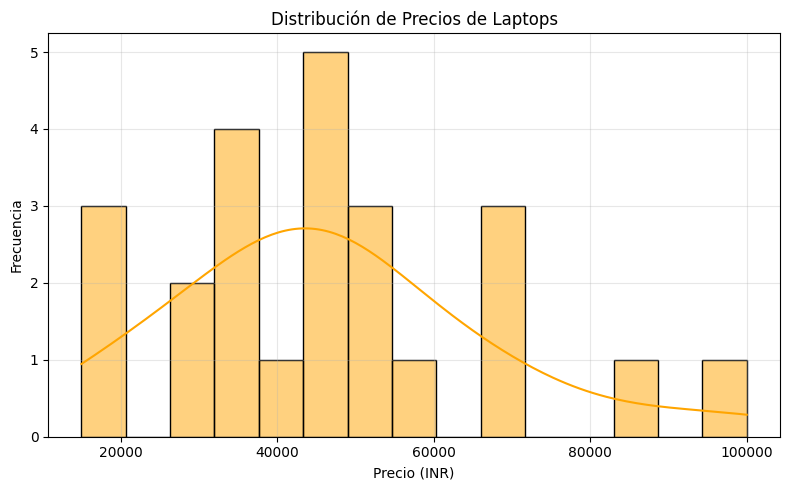

In [6]:
plt.figure(figsize=(8,5))
sns.histplot(df["Precio_num"].dropna(), bins=15, color="orange", kde=True)
plt.title("Distribución de Precios de Laptops")
plt.xlabel("Precio (INR)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("graf_distribucion_precios.png")
plt.show()

## 💵 Precio vs Rating (por marca)
Comparamos calificación promedio contra precio para distintas marcas.

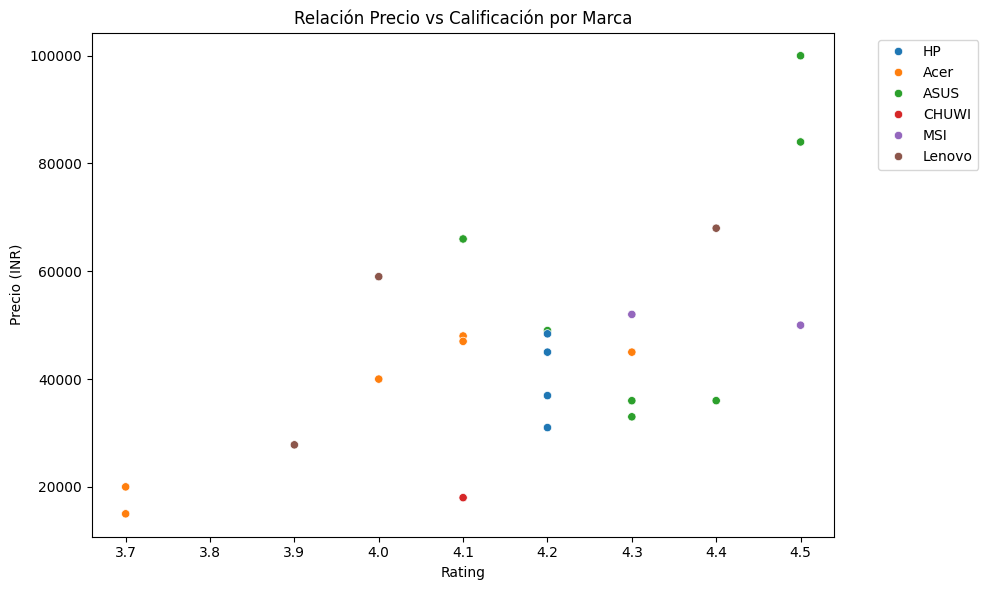

In [7]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="Rating_num", y="Precio_num", hue="Marca")
plt.title("Relación Precio vs Calificación por Marca")
plt.xlabel("Rating")
plt.ylabel("Precio (INR)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("graf_precio_vs_rating.png")
plt.show()

## 🥇 Top 10 laptops más caras y más baratas

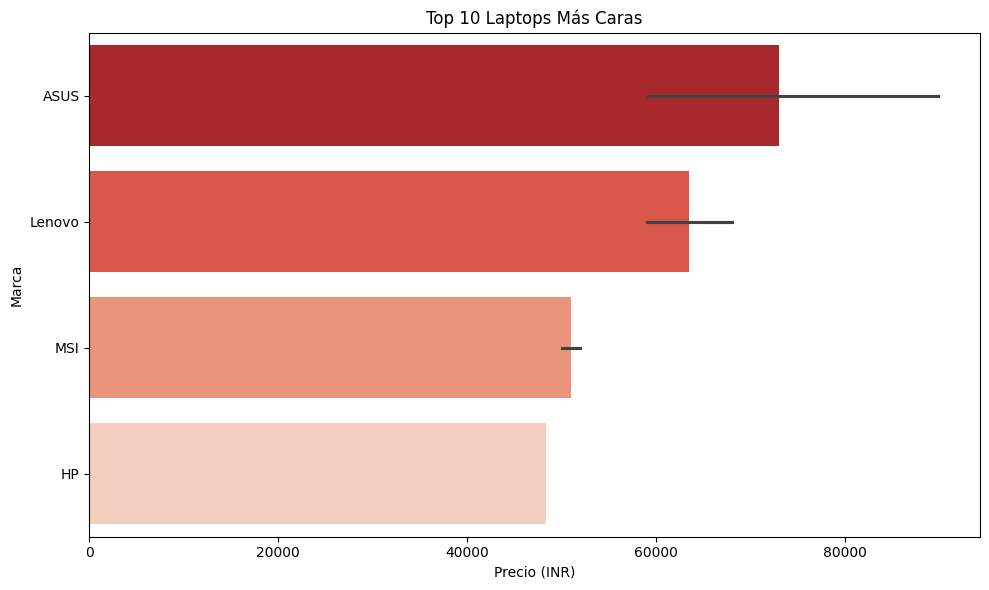

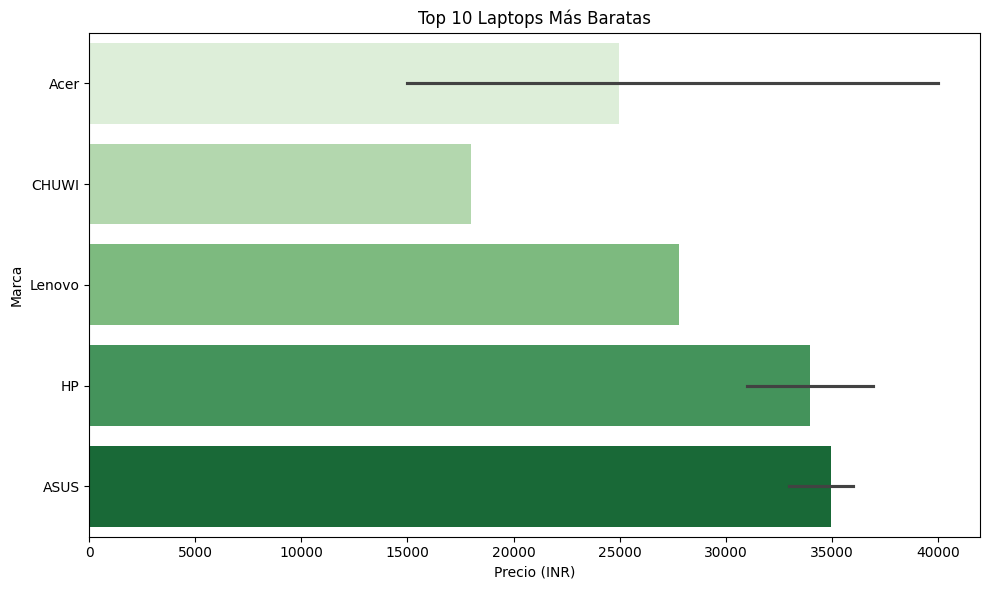

In [8]:
top10 = df.sort_values("Precio_num", ascending=False).head(10)
low10 = df.sort_values("Precio_num", ascending=True).head(10)

plt.figure(figsize=(10,6))
sns.barplot(y="Marca", x="Precio_num", hue="Marca", data=top10, palette="Reds_r")
plt.title("Top 10 Laptops Más Caras")
plt.xlabel("Precio (INR)")
plt.tight_layout()
plt.savefig("graf_top10_caras.png")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(y="Marca", x="Precio_num", hue="Marca", data=low10, palette="Greens")
plt.title("Top 10 Laptops Más Baratas")
plt.xlabel("Precio (INR)")
plt.tight_layout()
plt.savefig("graf_top10_baratas.png")
plt.show()

## Exportación de resultados
Guardamos tanto el dataset limpio como las gráficas en disco para su análisis posterior.

In [9]:
df.to_csv("flipkart_laptops_limpio.csv", index=False)
print("✅ Datos exportados correctamente.")

✅ Datos exportados correctamente.


### ¿Para ustedes, cuáles fueron las computadoras más caras? Muestra tu top 3!

In [10]:
df.sort_values(by="Precio_num", ascending=False).head(3)

,Producto,Rating,Especificaciones,Precio,Procesador,RAM,Almacenamiento,Sistema_Operativo,Rating_num,Precio_num,Producto_Limpio,Marca
20,"ASUS Zenbook A14 OLED (2025), Copilot + PC wit...",4.5,No disponible,"₹99,990",None,None,None,None,4.5,99990.0,"ASUS Zenbook A14 OLED (2025), Copilot + PC wit...",ASUS
13,ASUS Vivobook S 15 Intel Core i9 13th Gen 1390...,4.5,No disponible,"₹83,990",Intel Core i9 13th Gen 13900H,16 GB,16 GB/512 GB SSD,Windows 11,4.5,83990.0,ASUS Vivobook S 15 Intel Core i9 13th Gen 13900H,ASUS
14,Lenovo Yoga Slim 6 WUXGA OLED Intel Core i5 13...,4.4,No disponible,"₹67,990",Intel Core i5 13th Gen 13500H,16 GB,16 GB/512 GB SSD,Windows 11,4.4,67990.0,Lenovo Yoga Slim 6 WUXGA OLED Intel Core i5 13...,Lenovo


### ¿Para ustedes, cuáles fueron las computadoras con menor rating? Muestra tu top 3!

In [11]:
df.sort_values(by="Rating", ascending=True).head(3)

,Producto,Rating,Especificaciones,Precio,Procesador,RAM,Almacenamiento,Sistema_Operativo,Rating_num,Precio_num,Producto_Limpio,Marca
2,Acer Aspire 3 Intel Celeron Dual Core - (8 GB/...,3.7,No disponible,"₹14,990",Intel Celeron Dual Core,8 GB,8 GB/128 GB SSD,Windows 11,3.7,14990.0,Acer Aspire 3 Intel Celeron Dual Core,Acer
3,Acer Aspire 3 Intel Celeron Dual Core - (8 GB/...,3.7,No disponible,"₹19,990",Intel Celeron Dual Core,8 GB,8 GB/512 GB SSD,Windows 11,3.7,19990.0,Acer Aspire 3 Intel Celeron Dual Core,Acer
12,Lenovo V15 AMD Ryzen 3 Quad Core 7th Gen 7320U...,3.9,No disponible,"₹27,790",AMD Ryzen 3 Quad Core 7th Gen 7320U,8 GB,8 GB/512 GB SSD,Windows 11,3.9,27790.0,Lenovo V15 AMD Ryzen 3 Quad Core 7th Gen 7320U,Lenovo
